In [83]:
import numpy as np
import matplotlib.pyplot as plt

----------------Μέρος Α------------------

Υλοποίηση της κλάσης Classifier:

In [84]:
class Classifier:

    theta_estimation = None
    
    def fit(self, D, thetas):

        # Calculate for every sample and every theta, the probability p(x|theta)
        probs_x_theta = (1/np.pi) * (1 / (1 + (D[:, np.newaxis] - thetas)**2))  

        # Compute p(D|theta) as the product for each theta (along axis 0)
        probs_D_theta = np.prod(probs_x_theta, axis=0)

        # Get the value of theta that maximizes the probability p(D|theta)
        self.theta_estimation = thetas[np.argmax(probs_D_theta)]

        return probs_D_theta
    


Υπολογισμός της εκτίμησης του θ και plotting της πιθανότητας των dataset D1, D2
(ερώτημα α)

2.5250501002003958 
 -3.2464929859719476


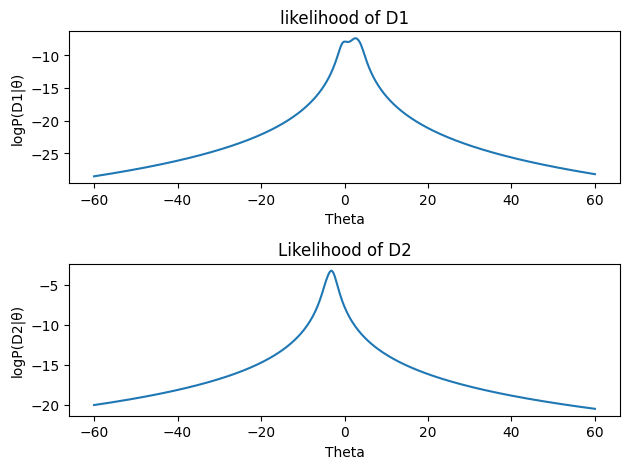

In [85]:
# Create 2 Classifier objects
class1 = Classifier()
class2 = Classifier()

# Fit models to observations 
D1 = np.array([2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1])
thetas1 = np.linspace(-60, 60, 500)
probs_D_theta1 = class1.fit(D1, thetas1)

D2 = np.array([-4.5, -3.4, -3.1, -3.0, -2.3])
thetas2 = np.linspace(-60, 60, 500)
probs_D_theta2 = class2.fit(D2, thetas2)

print(class1.theta_estimation, "\n", class2.theta_estimation)

# Plot log( p(D|theta) ) for both classes
fig, ax = plt.subplots(2, 1)
ax[0].plot(thetas1, np.log10(probs_D_theta1))
ax[0].set_title("likelihood of D1")
ax[0].set_xlabel("Theta")
ax[0].set_ylabel("logP(D1|θ)")
ax[1].plot(thetas2, np.log10(probs_D_theta2))
ax[1].set_xlabel("Theta")
ax[1].set_ylabel("logP(D2|θ)")
ax[1].set_title("Likelihood of D2")
fig.tight_layout()
plt.show()

(Ερώτημα β)